In [28]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [29]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [30]:
X = df["theta"]
y = df["z"]
X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)
X.shape, y.shape

((180, 1), (180, 1))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data_linear = lgb.Dataset(X_train, label=y_train, params = {'linear_tree': True,})
train_data_normal = lgb.Dataset(X_train, label=y_train, params = {'linear_tree': False,})

In [32]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 1,
    "verbosity": -1,
    'linear_tree': True,
    'num_iterations': 4,
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [33]:
y_pred_linear = model_linear.predict(X_test)
print(
    f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
y_pred_normal = model_normal.predict(X_test)
print(
    f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")
y_linear = model_linear.predict(X)
y_normal = model_normal.predict(X)

Linear trees error: 0.862
Normal trees error: 0.862


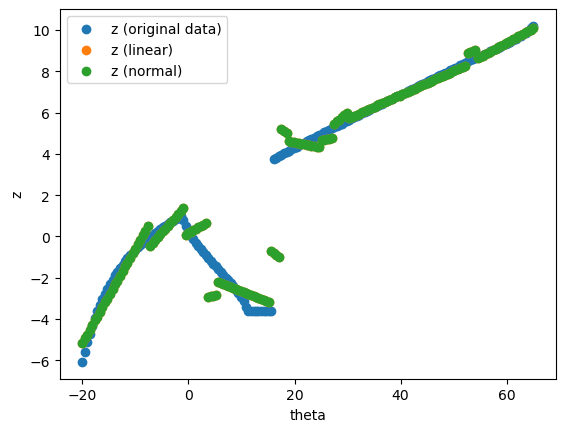

In [34]:
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, y_linear, label = 'z (linear)')
plt.scatter(X, y_normal, label = 'z (normal)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

# Threshold

In [35]:
print(model_linear.params)
model_linear.save_model('./output/model_observation_linear.txt')
model_normal.save_model('./output/model_observation_normal.txt')

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 1, 'verbosity': -1, 'linear_tree': True, 'num_iterations': 4, 'early_stopping_round': None}


the linear tree and the normal tree have different threshold.

# Split and then fit

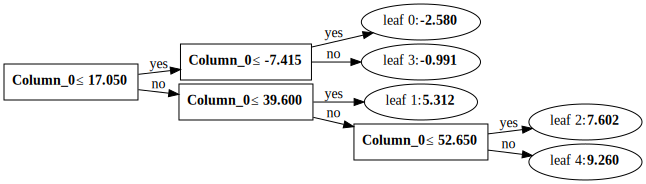

In [36]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
# p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
p = lgb.create_tree_digraph(model_linear, 0)
p

In [39]:
# I use a lazy way to compute the value of the first tree
bin_1, bin_2, bin_3, bin_4, bin_5 = [], [], [], [], []
for i in range(len(X_train)):
    if X_train[i] <= -7.415:
        bin_1.append(y_train[i])
    elif -7.415 <= X_train[i] <= 17.050:
        bin_2.append(y_train[i])
    elif 17.050 <= X_train[i] <= 39.6:
        bin_3.append(y_train[i])
    elif 39.6 <= X_train[i] <= 52.65:
        bin_4.append(y_train[i])
    else:
        bin_5.append(y_train[i])

avg_1, avg_2, avg_3, avg_4, avg_5 = np.average(bin_1), np.average(bin_2), np.average(bin_3), np.average(bin_4), np.average(bin_5)
for i in range(len(X_train)):
    if X_train[i] <= -7.415:
        y_train[i] -= avg_1
    elif -7.415 <= X_train[i] <= 17.050:
        y_train[i] -= avg_2
    elif 17.050 <= X_train[i] <= 39.6:
        y_train[i] -= avg_3
    elif 39.6 <= X_train[i] <= 52.65:
        y_train[i] -= avg_4
    else:
        y_train[i] -= avg_5

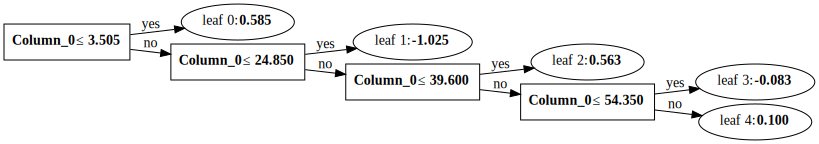

In [40]:
p = lgb.create_tree_digraph(model_linear, 1)
p

In [41]:
# I use a lazy way to compute the value of the first tree
bin_1x, bin_2x, bin_3x, bin_4x, bin_5x = [], [], [], [], []
bin_1y, bin_2y, bin_3y, bin_4y, bin_5y = [], [], [], [], []
for i in range(len(X_train)):
    if X_train[i] <= 3.505:
        bin_1x.append(X_train[i])
        bin_1y.append(y_train[i])
    elif 3.505 <= X_train[i] <= 24.850:
        bin_2x.append(X_train[i])
        bin_2y.append(y_train[i])
    elif 24.850 <= X_train[i] <= 39.6:
        bin_3x.append(X_train[i])
        bin_3y.append(y_train[i])
    elif 39.6 <= X_train[i] <= 54.35:
        bin_4x.append(X_train[i])
        bin_4y.append(y_train[i])
    else:
        bin_5x.append(X_train[i])
        bin_5y.append(y_train[i])

print(np.average(bin_1y), np.average(bin_2y), np.average(bin_3y), np.average(bin_4y), np.average(bin_5y))
reg1 = LinearRegression().fit(bin_1x, bin_1y)
reg1.coef_, reg1.intercept_

0.5849796250000001 -1.025276506410256 0.5629487179487187 -0.08297101449275268 0.09956521739130393


(array([[0.13550557]]), array([1.72227107]))

# How result is generated from each tree

In [42]:
params_1 = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.2,
    "verbosity": -1,
    'num_iterations': 4,
}

model_linear_1 = lgb.train(params_1, train_data_linear)
model_normal_1 = lgb.train(params_1, train_data_normal)


c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [43]:
# final result
result = model_linear_1.predict(X_test)

In [44]:
# result from tree 0
result0 = model_linear_1.predict(X_test, start_iteration=0, num_iteration=1)
# result from tree 1
result1 = model_linear_1.predict(X_test, start_iteration=1, num_iteration=1)
# result from tree 2
result2 = model_linear_1.predict(X_test, start_iteration=2, num_iteration=1)
# result from tree 3
result3 = model_linear_1.predict(X_test, start_iteration=3, num_iteration=1)

In [45]:
# final result is just a combination of all the results from each tree
result == result0 + result1 + result2 + result3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [46]:
# seleact a single input to test the result
X[0]
# observe manually from the txt file, the result from each tree is the following
2.184, 0.0916*(-11)+0.362, 0.0425*(-11)-0.175, 0.034*(-11)-0.14
# compare the result 
2.184+ 0.0916*(-11)+0.362+ 0.0425*(-11)-0.175+ 0.034*(-11)-0.14, result[0]

(0.38190000000000013, 0.38297190027799854)

this shows that the learning rate (shrinkage) is added to the coefficient and constant of each leaf

# Visualization of how each tree fit the data

In [47]:
# final result
result = model_linear.predict(X)
# result from tree 0
result0 = model_linear.predict(X, start_iteration=0, num_iteration=1)
# result from tree 1
result1 = model_linear.predict(X, start_iteration=1, num_iteration=1)
# result from tree 2
result2 = model_linear.predict(X, start_iteration=2, num_iteration=1)
# result from tree 3
result3 = model_linear.predict(X, start_iteration=3, num_iteration=1)

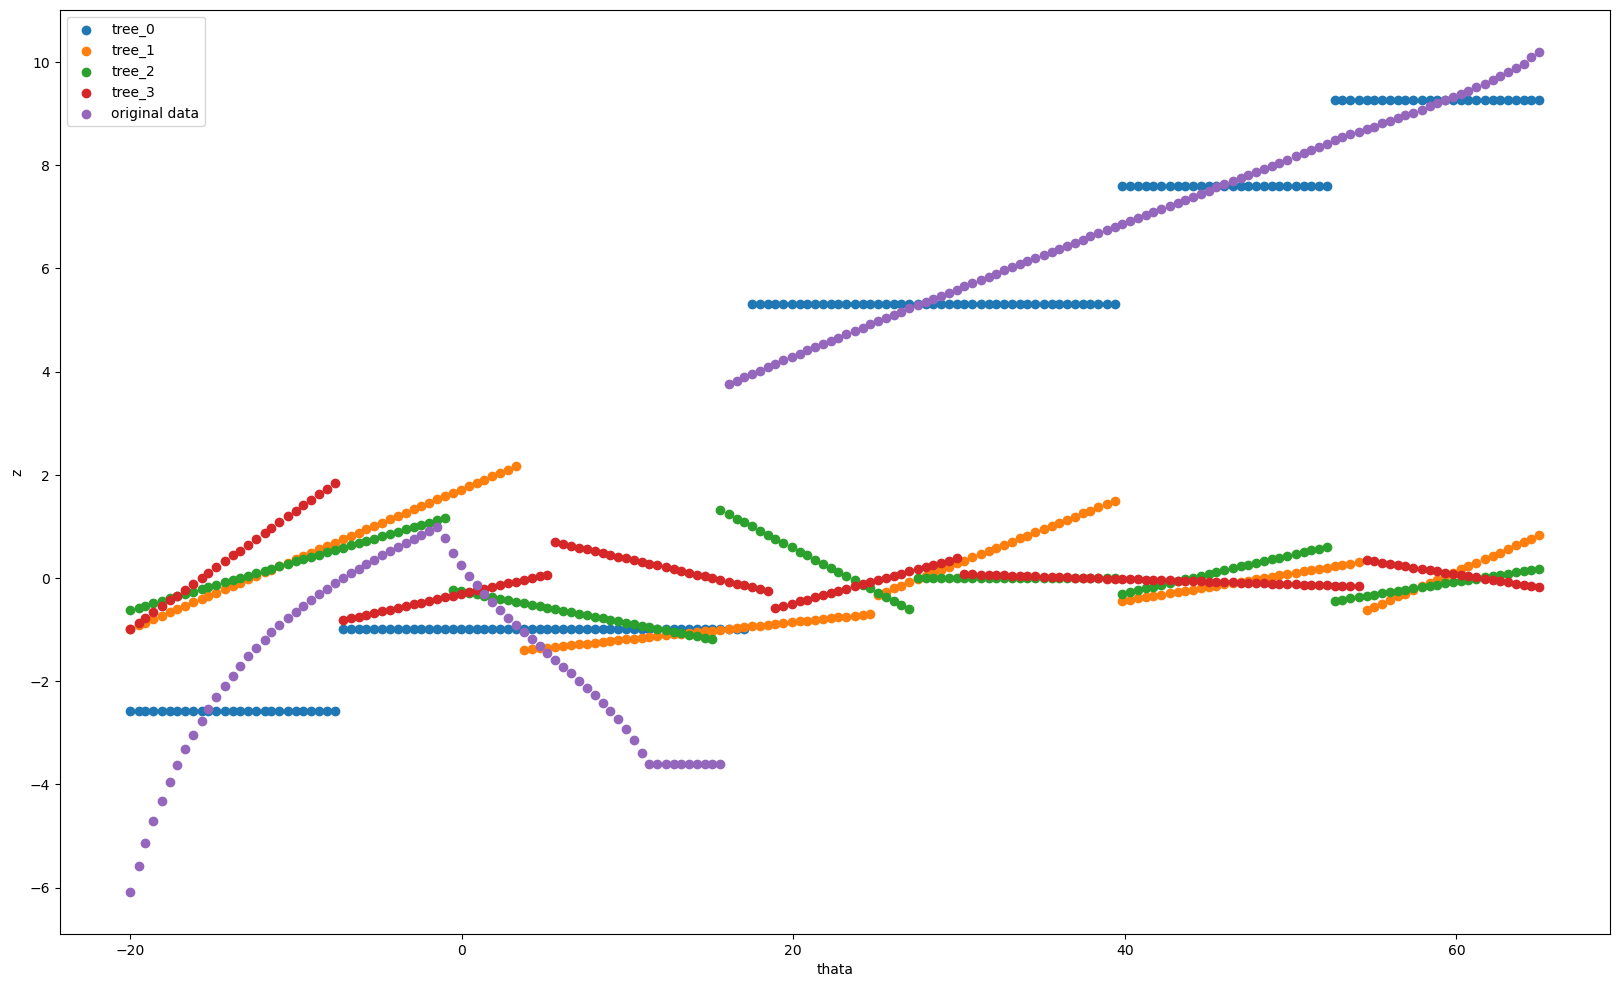

In [48]:
plt.figure(figsize=(20,12))
plt.scatter(X, result0 ,label='tree_0')
plt.scatter(X, result1 ,label='tree_1')
plt.scatter(X, result2 ,label='tree_2')
plt.scatter(X, result3 ,label='tree_3')
# plt.scatter(X, result, label='overall_tree')
plt.scatter(X, y, label = 'original data')
plt.legend()
plt.xlabel('thata')
plt.ylabel('z')
plt.show()

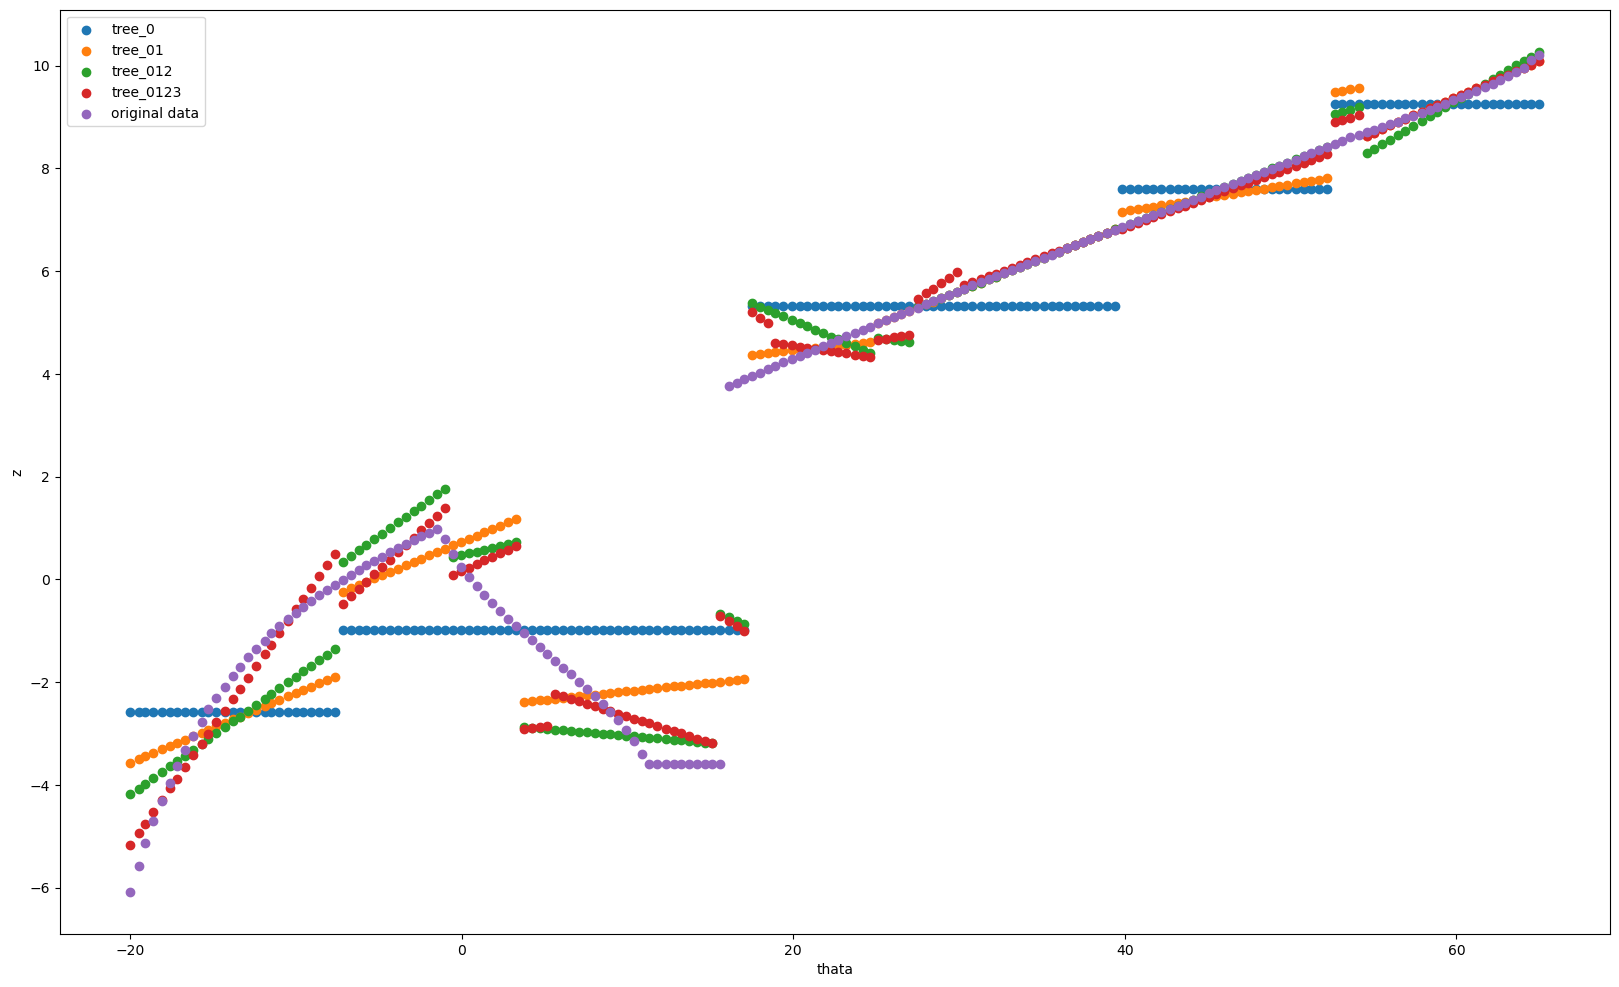

In [49]:
plt.figure(figsize=(20,12))
plt.scatter(X, result0, label='tree_0')
plt.scatter(X, result0 + result1, label='tree_01')
plt.scatter(X, result0 + result1 + result2, label='tree_012')
plt.scatter(X, result0 + result1 + result2 + result3, label='tree_0123')
# plt.scatter(X, result, label='overall_tree')
plt.scatter(X, y, label = 'original data')
plt.legend()
plt.xlabel('thata')
plt.ylabel('z')
plt.show()

# Parse

In [50]:
model_linear.dump_model()
# model_linear.trees_to_dataframe()

{'name': 'tree',
 'version': 'v3',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 0,
 'objective': 'regression',
 'average_output': False,
 'feature_names': ['Column_0'],
 'monotone_constraints': [],
 'feature_infos': {'Column_0': {'min_value': -20,
   'max_value': 65,
   'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 5,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 0,
    'split_gain': 2554.25,
    'threshold': 17.050000000000004,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 3.37509,
    'internal_weight': 0,
    'internal_count': 144,
    'left_child': {'split_index': 2,
     'split_feature': 0,
     'split_gain': 34.784400939941406,
     'threshold': -7.414999999999999,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': -1.5376699999999999,
     'internal_weight':

In [51]:
model_linear.dump_model()['tree_info'][0]["tree_structure"].keys()

dict_keys(['split_index', 'split_feature', 'split_gain', 'threshold', 'decision_type', 'default_left', 'missing_type', 'internal_value', 'internal_weight', 'internal_count', 'left_child', 'right_child'])

In [52]:
node = model_linear.dump_model()['tree_info'][0]["tree_structure"]
queue = [node]
tree_dict = {}
tree_dict["split"+str(queue[0]["split_index"])] = {'split_index': queue[0]["split_index"],
                                 'threshold': queue[0]["threshold"], }
while queue:
    if "left_child" in queue[0].keys():
        queue.append(queue[0]["left_child"])
        if "split_index" in queue[0]["left_child"].keys():
            tree_dict["split"+str(queue[0]["left_child"]["split_index"])] = {'split_index': queue[0]["left_child"]["split_index"],
                                                           'threshold': queue[0]["left_child"]["threshold"], }
        else:
            tree_dict["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'leaf_index': queue[0]["left_child"]["leaf_index"],
                                                          'value': queue[0]["left_child"]["leaf_value"], }
    if "right_child" in queue[0].keys():
        queue.append(queue[0]["right_child"])      
        if "split_index" in queue[0]["right_child"].keys():
            tree_dict["split"+str(queue[0]["right_child"]["split_index"])] = {'split_index': queue[0]["right_child"]["split_index"],
                                                           'threshold': queue[0]["right_child"]["threshold"], }
        else:
            tree_dict["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'leaf_index': queue[0]["right_child"]["leaf_index"],
                                                          'value': queue[0]["right_child"]["leaf_value"], }
    queue.pop(0)

tree_dict


{'split0': {'split_index': 0, 'threshold': 17.050000000000004},
 'split2': {'split_index': 2, 'threshold': -7.414999999999999},
 'split1': {'split_index': 1, 'threshold': 39.6},
 'leaf0': {'leaf_index': 0, 'value': -2.5798571129414505},
 'leaf3': {'leaf_index': 3, 'value': -0.9905150411159012},
 'leaf1': {'leaf_index': 1, 'value': 5.312051298418162},
 'split3': {'split_index': 3, 'threshold': 52.65000000000001},
 'leaf2': {'leaf_index': 2, 'value': 7.60238085277859},
 'leaf4': {'leaf_index': 4, 'value': 9.260434619151617}}